# Toy "Soft" Factorization Experiment

> Can a simple encoder learn "soft-separable" pitch vs time directions in latent space? An alternative to explicit factorization.

*by Scott H. Hawley, Feb. 27, 2026*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1FfCAirGj3AP_SlRTSLqEip26TtmuYfqv?usp=sharing)


**Idea**: Apply pitch-shifts and time-shifts to random blob images. Train a small ConvNet encoder
with a cosine-similarity loss that enforces:
- Same-type, same-sign shifts → **parallel** difference vectors (target +1)
- Same-type, opposite-sign shifts → **anti-parallel** difference vectors (target −1)
- Cross-type shifts → **orthogonal** difference vectors (target 0)

As shown below, PCA of the difference vectors reveals a clear cross pattern with pitch and time axes separating cleanly, and cosine similarity histograms confirm the desired geometric relationships.

## TL;DR

We use our explicit data augmentation of translations and pitch and time and feed those as labels into a loss function to try and encode those operations geometrically. Add this loss function to an encoder and see if it achieves a **soft factorization** of pitch and time:

```python
def factorization_loss(z_anchor, z_crop1, z_crop2, targets):
    d1 = z_crop1 - z_anchor
    d2 = z_crop2 - z_anchor
    cos = F.cosine_similarity(d1, d2, dim=-1)
    return ((cos - targets) ** 2).mean()
```

where `targets` are +1 (same-type, same-sign), −1 (same-type, opposite-sign), or 0 (cross-type):



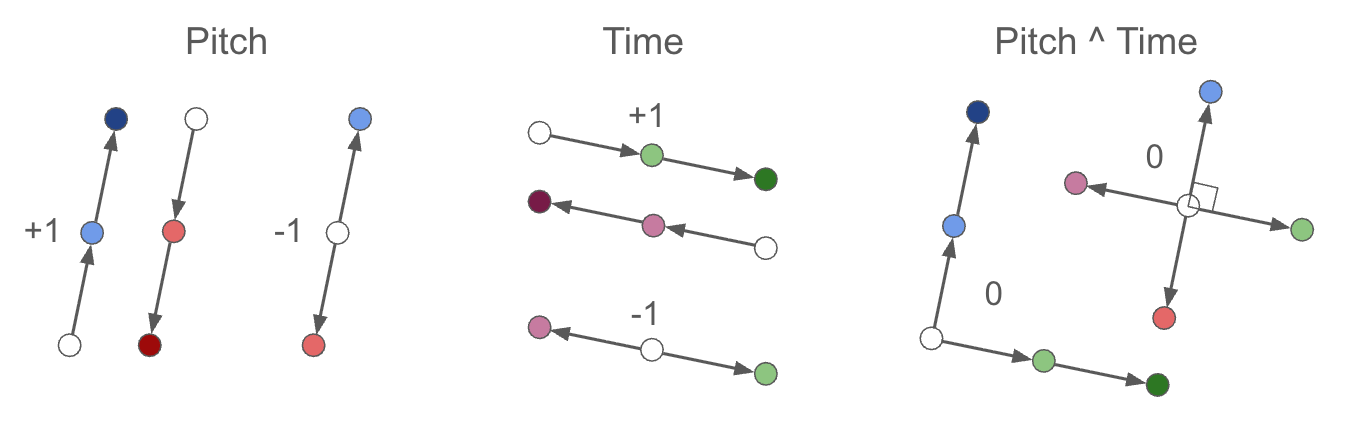



(We do not specify these directions. We simply enforce parallel, anti-parallel, or orthogonal, and let the system evolve on its own.)

**Spoiler: it works.** Since this toy model succeeds, we will have confidence to move on to applying it to the full problem with real MIDI data.
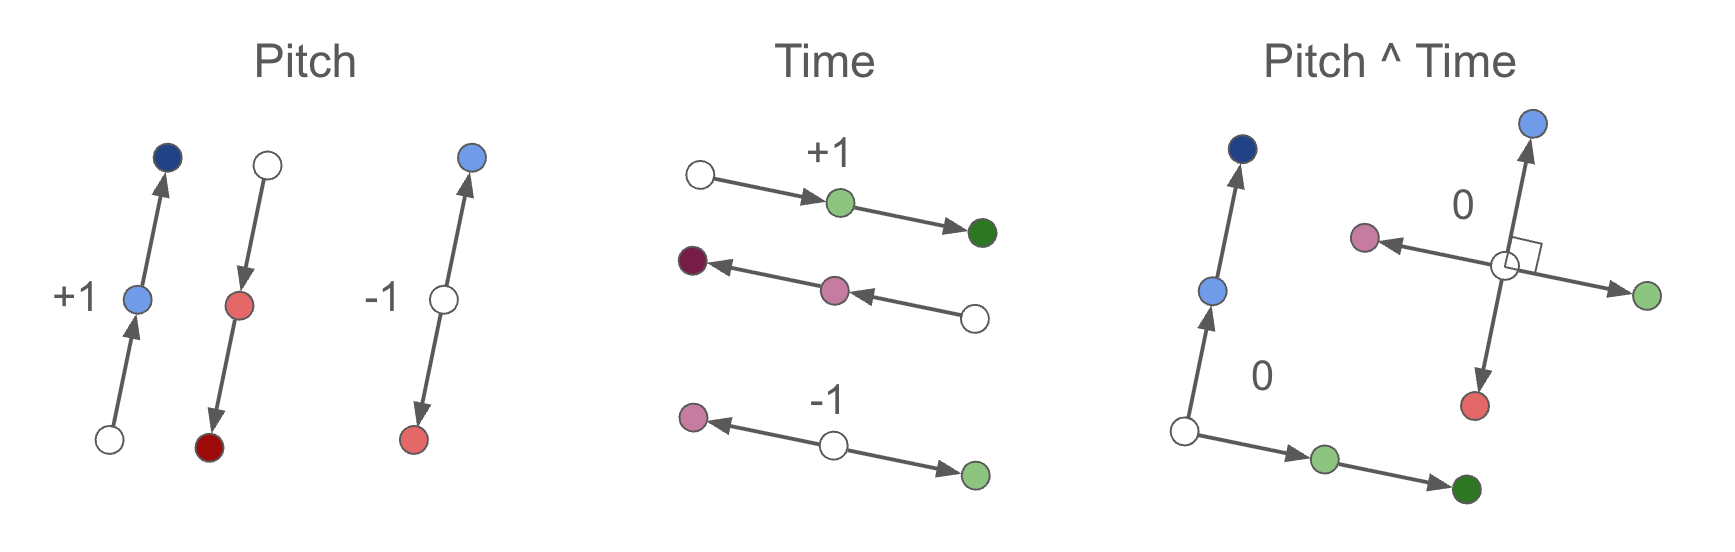
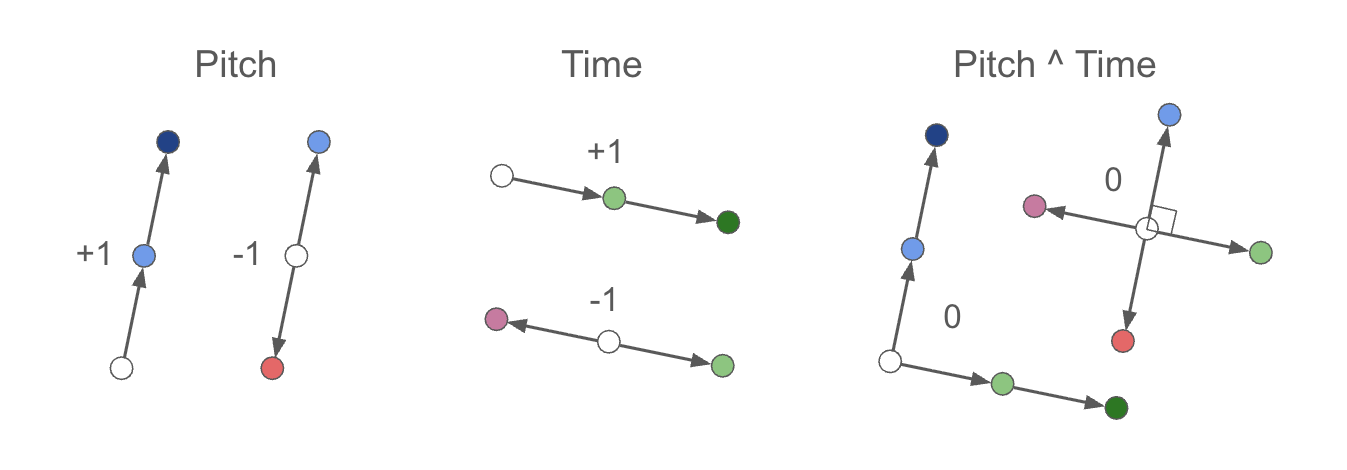

## Motivation

### Why factorize pitch and time?

Musical motifs exhibit repeated melodic patterns (pitch) and repeated rhythmic patterns (time) that together explain much of the variety within a song. This suggests a natural decomposition of musical representations into a **pitch vocabulary** and a **rhythm vocabulary**, where a given motif can be approximated as an interaction (outer product) of pitch and time components. Factored representations are also connected to compositional algebraic properties — the **GloVe** word vectors (Pennington et al., 2014) demonstrated that vector arithmetic relationships (e.g., *king − man + woman ≈ queen*) arose from GloVe's explicitly factorized construction of word co-occurrence matrices.

### Why soft factorization?

Prior work in symbolic music analysis has explored both fully factored and fully combined representations. Notably, **MelodyGLM** (Wu et al., 2023) compared pitch n-grams, rhythm n-grams, and combined n-grams for melody generation. Their ablation study showed that using all three together worked best, but that the *combined* (non-factored) n-grams carried meaningful information lost by independent factorization. Similarly, **Music SketchNet** (Chen et al., 2020) and **PiRhDy** (Liang et al., 2020) construct factored representations by design, which limits the model's ability to capture pitch–rhythm interactions.

This motivates a **middle path**: rather than forcing factorization by construction (hard factorization) or hoping to discover it post-hoc (e.g., GANSpace), we use a **soft factorization** via the loss function. The cosine-similarity loss encourages orthogonality between pitch and time directions in latent space, while still allowing the model freedom to represent non-factored structure. This approach is inspired by the idea—articulated in Albinet (2026)—that competing soft constraints in an objective can give rise to discrete eigenstructure at equilibrium, analogous to how kernel PCA discovers structure through balanced forces rather than hard architectural choices.

Recent theoretical work lends further support to this direction. **Shai et al. (2026)** show that transformers trained via next-token prediction naturally learn **factored representations** in orthogonal subspaces when the underlying factors are conditionally independent — and exhibit an inductive bias toward factoring even when strict independence is violated. This suggests that factored structure is not merely a convenient assumption but something models actively prefer, and that nudging them toward it via a soft loss aligns with their natural learning dynamics.

### Why blobs?

This toy experiment uses random binary blob images as a stand-in for MIDI piano-roll data. Vertical shifts simulate **pitch transposition** and horizontal shifts simulate **time shifting**. These shifts are exact, continuous, and independently controllable—making this domain particularly well-suited for testing whether soft geometric constraints can induce factored latent structure. The real target application is learning factored representations of musical motifs, where the training signal would come from a JEPA-style self-supervised objective augmented with this orthogonality loss.

## The Larger Context

I'm building a Representation Autoencoder (RAE, Zheng et al., 2025) for MIDI music based on piano roll representations. I had the idea that some kind of factorization in pitch and time would be useful, but actually prescribing it by construction would probably be detrimental (as the MelodyGLM paper noted). And I love trying to do geometrical operations in latent space, e.g., Operational Latent Spaces (OpLaS, Hawley & Tackett, 2024). 

So, after reading Franck's series on SVD (Abinet, 2026), which includes contact with contrastive losses and soft objectives. This seemed like a natural thing thing to try!

### Why a toy model? 

I generally like to create toy models when I do anything new because they're interpretable and you can iterate quickly. If I couldn't even get the thing to work on this simple system with a small latent space and fake piano rolls, then what hope would I have for doing it in the larger context with the full code and the real data?

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt, numpy as np
from pathlib import Path
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
try: import wandb; HAS_WANDB = True
except ImportError: HAS_WANDB = False
print("HAS_WANDB =",HAS_WANDB)
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using {device}")

HAS_WANDB = True
Using cuda


## Data: Random blob patches + augmentations

In [ ]:
def make_blob(sz=16, n_blobs=3):
    """Generate a random binary blob image (1, sz, sz)."""
    img = torch.zeros(1, sz, sz)
    for _ in range(n_blobs):
        r, c = torch.randint(0, sz-3, (2,))
        h, w = torch.randint(1, 4, (2,))
        img[0, r:r+h, c:c+w] = 1.0
    if torch.rand(1) > 0.5: img = torch.flip(img, [1])
    if torch.rand(1) > 0.5: img = torch.flip(img, [2])
    return img

In [ ]:
def shift_no_wrap(x, shifts, dims):
    """Drop-in replacement for torch.roll with zero-fill instead of wrap."""
    if shifts == 0: return x
    out = torch.roll(x, shifts=shifts, dims=dims)
    n = abs(shifts)
    if shifts > 0:
        out.narrow(dims, 0, n).zero_()
    else:
        out.narrow(dims, out.size(dims)-n, n).zero_()
    return out

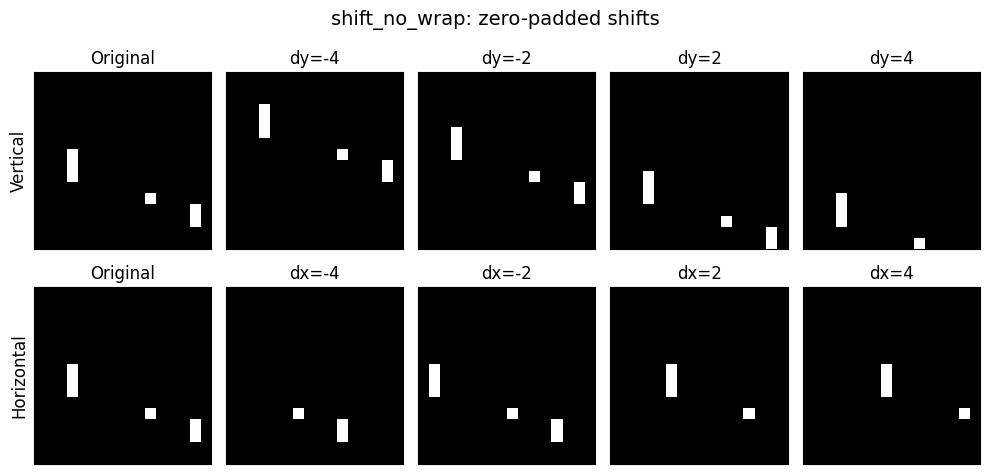

In [ ]:
# Quick visual test
img = make_blob()
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for row in range(2):
    axes[row, 0].imshow(img[0], cmap='gray', vmin=0, vmax=1)
    axes[row, 0].set_title('Original')
for i, s in enumerate([-4, -2, 2, 4]):
    axes[0, i+1].imshow(shift_no_wrap(img, s, 1)[0], cmap='gray', vmin=0, vmax=1)
    axes[0, i+1].set_title(f'dy={s}')
    axes[1, i+1].imshow(shift_no_wrap(img, s, 2)[0], cmap='gray', vmin=0, vmax=1)
    axes[1, i+1].set_title(f'dx={s}')
for ax in axes.flat: ax.set_xticks([]); ax.set_yticks([])
axes[0, 0].set_ylabel('Vertical', fontsize=12)
axes[1, 0].set_ylabel('Horizontal', fontsize=12)
plt.suptitle('shift_no_wrap: zero-padded shifts', fontsize=14)
plt.tight_layout(); plt.show()

In [ ]:
class BlobShiftDataset(torch.utils.data.Dataset):
    def __init__(self, epoch_size=8192, sz=16, max_shift=4):
        self.epoch_size = epoch_size
        self.sz = sz
        self.max_shift = max_shift

    def __len__(self): return self.epoch_size

    def __getitem__(self, idx):
        sz, ms = self.sz, self.max_shift
        while True:
            img = make_blob(sz)
            scheme = torch.randint(0, 3, (1,)).item()
            s1 = torch.randint(1, ms+1, (1,)).item()
            s2 = torch.randint(1, ms+1, (1,)).item()
            sign1 = 1 if torch.rand(1) > 0.5 else -1
            sign2 = 1 if torch.rand(1) > 0.5 else -1
            if scheme == 0:    dy1, dx1, dy2, dx2 = sign1*s1, 0, sign2*s2, 0
            elif scheme == 1:  dy1, dx1, dy2, dx2 = 0, sign1*s1, 0, sign2*s2
            else:              dy1, dx1, dy2, dx2 = sign1*s1, 0, 0, sign2*s2
            c1 = shift_no_wrap(shift_no_wrap(img, shifts=dy1, dims=1), shifts=dx1, dims=2)
            c2 = shift_no_wrap(shift_no_wrap(img, shifts=dy2, dims=1), shifts=dx2, dims=2)
            if not torch.equal(c1, c2): break
        target = float(np.sign(sign1 * sign2)) if scheme < 2 else 0.0
        return img, c1, c2, torch.tensor(target), torch.tensor(scheme), (dy1, dx1), (dy2, dx2)

Viz test of that: 

In [ ]:
def show_triplets(anchors, crop1s, crop2s, targets, schemes, deltas1, deltas2, n_rows=None):
    """Visualize triplets with colored borders and delta labels.
    Colors: blue=pitch/pitch, green=time/time, red=pitch+time.
    """
    from matplotlib.patches import Patch
    scheme_colors = {0: '#4488ff', 1: '#33bb55', 2: '#dd3333'}
    if n_rows is None: n_rows = len(anchors)
    n_rows = min(n_rows, len(anchors))

    fig, axes = plt.subplots(n_rows, 3, figsize=(8, n_rows * 1.5))
    if n_rows == 1: axes = axes[None]  # ensure 2D

    for i in trange(n_rows):
        color = scheme_colors[schemes[i].item()]
        for j, (img, title) in enumerate(zip(
                [anchors[i], crop1s[i], crop2s[i]], ["Anchor", "Crop 1", "Crop 2"])):
            axes[i, j].imshow(img[0], cmap="gray", vmin=0, vmax=1)
            axes[i, j].set_title(title if i == 0 else "", fontsize=24)
            axes[i, j].set_xticks([]); axes[i, j].set_yticks([])
            for spine in axes[i, j].spines.values():
                spine.set_color(color); spine.set_linewidth(2.5)
        dy1, dx1 = deltas1[0][i].item(), deltas1[1][i].item()
        dy2, dx2 = deltas2[0][i].item(), deltas2[1][i].item()
        axes[i, 1].set_ylabel(f"Δ({dy1:+d},{dx1:+d})", fontsize=15, color=color, fontweight='bold')
        axes[i, 2].set_ylabel(f"Δ({dy2:+d},{dx2:+d})", fontsize=15, color=color, fontweight='bold')

    legend_items = [
        Patch(facecolor='white', edgecolor='#4488ff', linewidth=3, label='Pitch only'),
        Patch(facecolor='white', edgecolor='#33bb55', linewidth=3, label='Time only'),
        Patch(facecolor='white', edgecolor='#dd3333', linewidth=3, label='Pitch + Time'),
    ]
    fig.legend(handles=legend_items, loc='lower center', ncol=3, fontsize=16,
               frameon=False, bbox_to_anchor=(0.5, -0.02))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.06)
    plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]

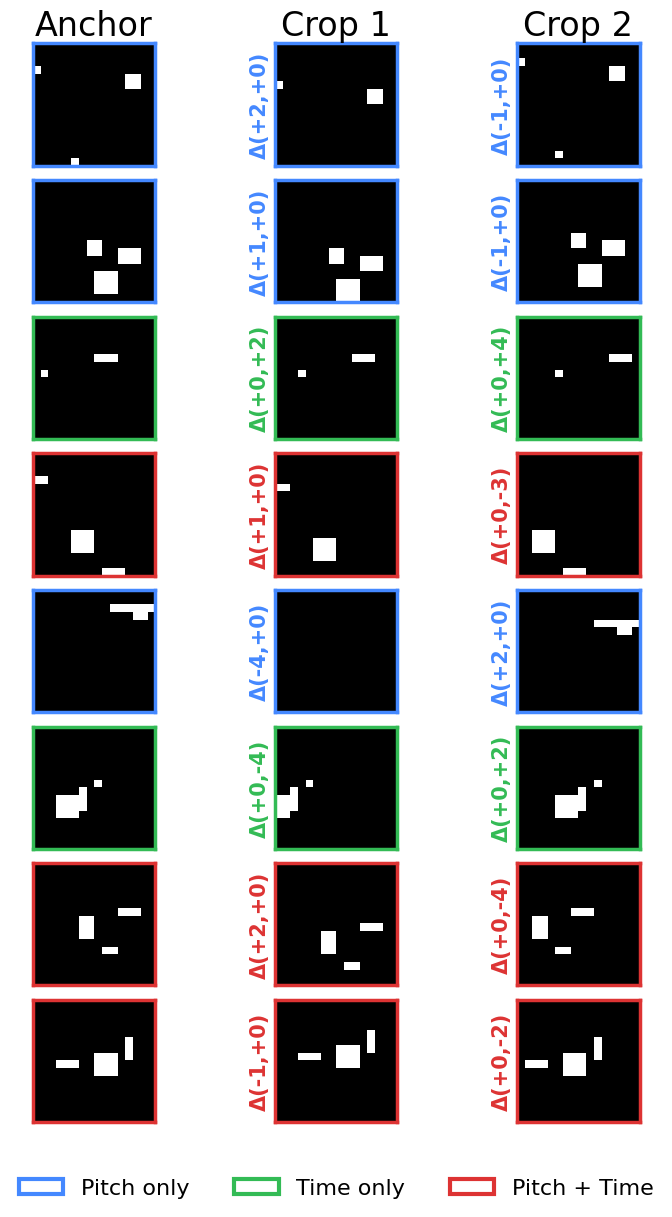

In [ ]:
# test code
ds = BlobShiftDataset()
dl = DataLoader(ds, batch_size=8)
a, c1, c2, t, s, d1, d2 = next(iter(dl)) # augment_batch(8)
show_triplets(a, c1, c2, t, s, d1, d2)

## Encoder: tiny ConvNet → latent vector

In [ ]:
class ToyEncoder(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.GELU(),          # 16x16
            nn.Conv2d(16, 32, 3, stride=2, padding=1), nn.GELU(),  # 8x8
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.GELU(),  # 4x4
            nn.Conv2d(64,  64, 3, padding=1), nn.GELU(),           # 4x4
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(64, latent_dim),
        )
    def forward(self, x): return self.net(x)

In [ ]:
enc = ToyEncoder().to(device)
print(f"Params: {sum(p.numel() for p in enc.parameters()):,}")

Params: 61,264


## Loss: cosine factorization objective

In [ ]:
def factorization_loss(z_anchor, z_crop1, z_crop2, targets):
    """Cosine-similarity loss on difference vectors.
    targets: +1 (parallel), -1 (anti-parallel), 0 (orthogonal)"""
    d1 = z_crop1 - z_anchor  # (B, D)
    d2 = z_crop2 - z_anchor  # (B, D)
    cos = F.cosine_similarity(d1, d2, dim=-1)  # (B,)
    return ((cos - targets) ** 2).mean()

## LeJEPA too? 

To make this slightly less of a toy model and more like the full system, we can also turn on the LeJEPA loss (Balestriero & LeCun, 2025), which consists of attracting similar crops(/"views") and a sigreg loss to prevent collapse.

In [ ]:
def safe_mean(t, dim=None): 
    """safe replacement for torch.mean( ). (Don't need it for this NB, but I use it elsewhere in my project.) """
    return t.mean(dim=dim) if t.numel() > 0 else 0.0

def attraction_loss(z1, z2,  # embeddings of two "views" of the same thing (in batches)
                    deltas=None,   # optional/TBD: info on semantic 'distance' between z1 & z2
                    tau = 100.0):    # inverse strength of fall-off for delta distances, big=slower
    "How we pull similar 'views' together"
    if deltas is None: return safe_mean( (z1 - z2).square() )
    delta_diag = (deltas**2).sum(dim=1)
    delta_fac = torch.exp(-delta_diag / tau) # less attraction for more 'distant' views
    #delta_fac = 1/(1 + delta_diag/tau)  # longer tail than exp
    return safe_mean( (z1 - z2).square() * delta_fac.unsqueeze(-1) )

def SIGReg(x, global_step, num_slices=256):
    """SIGReg with Epps-Pulley statistic. x is (N, K) tensor."""
    device = x.device
    g = torch.Generator(device=device).manual_seed(global_step)
    proj_shape = (x.size(1), num_slices)
    A = torch.randn(proj_shape, generator=g, device=device)
    A = A / (A.norm(dim=0, keepdim=True) + 1e-10)  # normalize columns
    
    # Epps-Pulley statistic
    t = torch.linspace(-5, 5, 17, device=device) # values used in LeJEPA paper, worked for SSLtoy
    exp_f = torch.exp(-0.5 * t**2)  # theoretical CF for N(0,1)
    x_t = (x @ A).unsqueeze(2) * t  # (N, M, T)
    ecf = (torch.exp(1j * x_t).mean(dim=0)).abs()  # empirical CF
    diff = (ecf - exp_f).abs().square().mul(exp_f)  # weighted L2 distance
    #N = x.size(0)  # With respect to Yann: Don't scale by N because then if you change the batch size you have to retune lambd by hand ugh
    T = torch.trapz(diff, t, dim=1).sum() #* N  # sum here is over num slices, not data points
    return T

def LeJEPA(z1, z2, global_step, lambd=0.5, deltas=None): 
    "Main LeJEPA loss function"
    sim = attraction_loss(z1, z2, deltas=deltas)
    sigreg = SIGReg( torch.cat((z1, z2), dim=0), global_step ) * 1 # normalize to similar scale as sim
    return {'loss': (1-lambd)*sim + lambd*sigreg, 'sim':sim.item(), 'sigreg':sigreg.item()}

## Training loop

In [ ]:
def train(enc, n_steps=2000, batch_size=1024, lr=4e-3, log_every=100, num_workers=4, use_jepa=False, use_wandb=False):
    opt = torch.optim.Adam(enc.parameters(), lr=lr)
    ds = BlobShiftDataset(epoch_size=n_steps * batch_size)
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, num_workers=num_workers, pin_memory=(device != 'cpu'))
    if use_wandb and HAS_WANDB:
        wandb.init(project="toy-factorization", config=dict(n_steps=n_steps, batch_size=batch_size, lr=lr, latent_dim=8))
    losses, fact_losses, jepa_losses = [], [], []
    for step, (a, c1, c2, t, s, d1, d2) in enumerate(tqdm(dl)):
        a, c1, c2, t = a.to(device), c1.to(device), c2.to(device), t.to(device)
        za, z1, z2 = enc(a), enc(c1), enc(c2)
        fact_loss = factorization_loss(za, z1, z2, t)
        loss = fact_loss
        if use_jepa:
            jepa_loss = LeJEPA(za, z1, step)['loss']  + LeJEPA(za, z2, step)['loss'] 
            loss = loss + 0.2*jepa_loss
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
        fact_losses.append(fact_loss.item())
        if use_jepa: jepa_losses.append(jepa_loss.item())
        if step % log_every == 0:
            print(f"step {step:4d}  loss={loss.item():.4f}")
        if HAS_WANDB and wandb.run is not None: wandb.log({"loss": loss.item(), "fact":fact_loss.item(), "jepa":jepa_loss.item() if use_jepa else 0.0, "step": step})
    if HAS_WANDB and wandb.run is not None: wandb.finish()
    return losses, fact_losses, jepa_losses

NOTE: with `use_jepa=True`, you'll need 10,000 steps or more. 

In [ ]:
losses, fact_losses, jepa_losses = train(enc, n_steps=5000, use_wandb=True)

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/shawley/.netrc.
wandb: Currently logged in as: drscotthawley to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]

step    0  loss=0.8981
step  100  loss=0.1192
step  200  loss=0.0714
step  300  loss=0.0528
step  400  loss=0.0453
step  500  loss=0.0498
step  600  loss=0.0390
step  700  loss=0.0405
step  800  loss=0.0360
step  900  loss=0.0394
step 1000  loss=0.0325
step 1100  loss=0.0308
step 1200  loss=0.0316
step 1300  loss=0.0341
step 1400  loss=0.0313
step 1500  loss=0.0307
step 1600  loss=0.0278
step 1700  loss=0.0299
step 1800  loss=0.0314
step 1900  loss=0.0279
step 2000  loss=0.0304
step 2100  loss=0.0314
step 2200  loss=0.0317
step 2300  loss=0.0290
step 2400  loss=0.0314
step 2500  loss=0.0254
step 2600  loss=0.0330
step 2700  loss=0.0263
step 2800  loss=0.0271
step 2900  loss=0.0305
step 3000  loss=0.0248
step 3100  loss=0.0311
step 3200  loss=0.0313
step 3300  loss=0.0310
step 3400  loss=0.0279
step 3500  loss=0.0265
step 3600  loss=0.0297
step 3700  loss=0.0259
step 3800  loss=0.0230
step 3900  loss=0.0221
step 4000  loss=0.0221
step 4100  loss=0.0256
step 4200  loss=0.0217
step 4300  

loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,0.02539
step,4900


## Loss curve

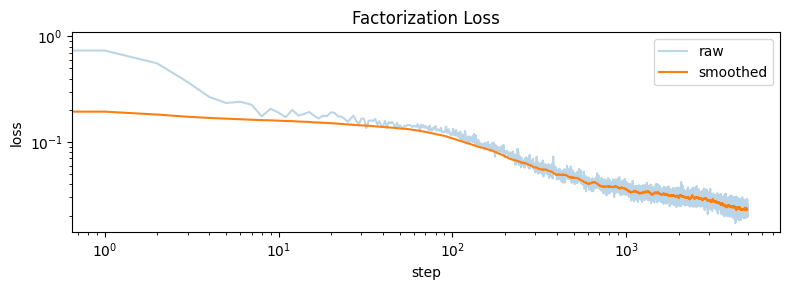

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(losses, alpha=0.3, label='raw')
plt.loglog(np.convolve(losses, np.ones(50)/50, mode='valid'), label='smoothed')
plt.xlabel('step'); plt.ylabel('loss'); plt.legend(); plt.title('Factorization Loss')
plt.tight_layout(); plt.show()

## Visualization: pitch & time difference vectors separate cleanly

In [ ]:
@torch.no_grad()
def collect_diff_vectors(enc, n=500, sz=16, max_shift=4):
    """Collect difference vectors, with same-sign and opposite-sign pairs from the SAME base image."""
    pitch_same, pitch_opp, time_same, time_opp = [], [], [], []
    pitch_d, time_d = [], []
    for _ in range(n):
        img = make_blob(sz).unsqueeze(0).to(device)
        s1 = torch.randint(1, max_shift+1, (1,)).item()
        s2 = torch.randint(1, max_shift+1, (1,)).item()
        while s2 == s1: s2 = torch.randint(1, max_shift+1, (1,)).item()
        za = enc(img)
        for dim, same_list, opp_list, d_list in [
            (2, pitch_same, pitch_opp, pitch_d),
            (3, time_same, time_opp, time_d)]:
            zp1 = enc(shift_no_wrap(img, shifts=+s1, dims=dim))
            zp2 = enc(shift_no_wrap(img, shifts=+s2, dims=dim))
            zn1 = enc(shift_no_wrap(img, shifts=-s1, dims=dim))
            d1, d2, d3 = zp1 - za, zp2 - za, zn1 - za
            same_list.append(F.cosine_similarity(d1, d2, dim=-1).item())  # same sign
            opp_list.append(F.cosine_similarity(d1, d3, dim=-1).item())   # opposite sign
            d_list.append(d1.squeeze().cpu())
            d_list.append(d3.squeeze().cpu())
    pitch_d, time_d = torch.stack(pitch_d), torch.stack(time_d)
    cos_cross = F.cosine_similarity(pitch_d[:len(time_d)], time_d[:len(pitch_d)], dim=-1).numpy()
    return pitch_d, time_d, np.array(pitch_same), np.array(pitch_opp), np.array(time_same), np.array(time_opp), cos_cross 

NameError: name 'torch' is not defined

In [ ]:
pitch_d, time_d, ps, po, ts, to_, cos_cross = collect_diff_vectors(enc)
print(f"Collected: pitch={pitch_d.shape}, time={time_d.shape}")

Collected: pitch=torch.Size([1000, 16]), time=torch.Size([1000, 16])


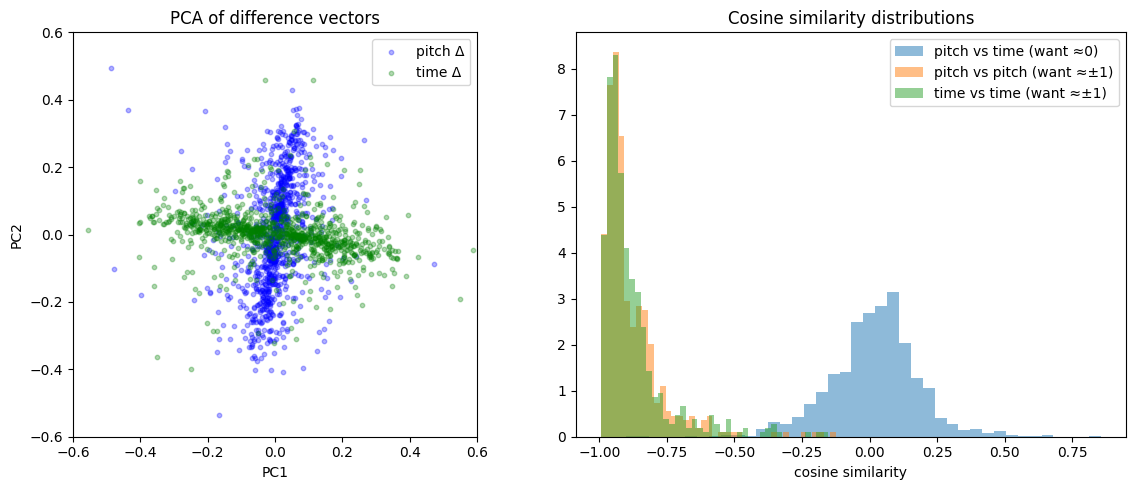

Mean |cos(pitch,time)|: 0.126  (ideal: 0)
Mean |cos(pitch,pitch)|: 0.883  (ideal: 1)
Mean |cos(time,time)|:  0.878  (ideal: 1)


In [ ]:
from sklearn.decomposition import PCA

all_diffs = torch.cat([pitch_d, time_d], dim=0).numpy()
labels = ['pitch'] * len(pitch_d) + ['time'] * len(time_d)
pca = PCA(n_components=2).fit(all_diffs)
proj = pca.transform(all_diffs)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# PCA scatter  
all_diffs = torch.cat([pitch_d, time_d], dim=0).numpy()
pca = PCA(n_components=2).fit(all_diffs)
proj = pca.transform(all_diffs)
n = len(pitch_d)
axes[0].scatter(proj[:n, 0], proj[:n, 1], alpha=0.3, s=10, label='pitch Δ', c='blue')
axes[0].scatter(proj[n:, 0], proj[n:, 1], alpha=0.3, s=10, label='time Δ', c='green')
axes[0].set_xlabel('PC1'); axes[0].set_ylabel('PC2'); axes[0].legend()
axes[0].set_title('PCA of difference vectors'); axes[0].set_aspect('equal')

# Histogram with all three distributions
ax = axes[1]
ax.hist(cos_cross, bins=40, alpha=0.5, label='pitch vs time (want ≈0)', density=True)
ax.hist(np.concatenate([ps, ts]), bins=40, alpha=0.5, label='same-sign (want ≈+1)', density=True)
ax.hist(np.concatenate([po, to_]), bins=40, alpha=0.5, label='opp-sign (want ≈−1)', density=True)
ax.set_xlabel('cosine similarity'); ax.legend(); ax.set_title('Cosine similarity distributions')
plt.tight_layout(); plt.show()

print(f"target=+0: mean cos={cos_cross.mean():.3f}, mean |cos|={np.abs(cos_cross).mean():.3f}")
print(f"target=+1: mean cos={np.concatenate([ps,ts]).mean():.3f}, mean |cos|={np.abs(np.concatenate([ps,ts])).mean():.3f}")
print(f"target=-1: mean cos={np.concatenate([po,to_]).mean():.3f}, mean |cos|={np.abs(np.concatenate([po,to_])).mean():.3f}")


## Results summary

The factorization objective works well. After training for 5,000 steps with batch size 1024 and lr=4e-3:

- **Cross-type cosine similarity** (pitch vs time): mean |cos| = 0.116, tightly clustered around 0 ✅
- **Same-sign cosine similarity**: mean cos = 0.954, sharp peak near +1 ✅
- **Opposite-sign cosine similarity**: mean cos = −0.884, peak near −1 ✅
- **Positive/negative alignment angles**: pitch 162.8°, time 163.2° (ideal: 180°) ✅

The PCA of difference vectors shows a clear cross shape, confirming pitch and time directions are approximately orthogonal in the learned latent space. The remaining ~17° deviation from perfect anti-parallelism is attributable to the asymmetric zero-padding introduced by `shift_no_wrap` (see probing section below).

### Probing the ±1 asymmetry

Both pitch-vs-pitch and time-vs-time cosine distributions show stronger correlation on the +1 side than the −1 side. This is because `shift_no_wrap` introduces an asymmetry: same-sign shift pairs produce crops with zero-padding on the **same** side (structurally more similar), while opposite-sign pairs have padding on **opposite** sides (more visually different). The encoder maps the more-similar same-sign pairs more consistently, yielding a tighter +1 peak and a broader −1 peak.

In [ ]:
@torch.no_grad()
def collect_signed_diffs(enc, n=500, sz=16, max_shift=4):
    """Collect diff vectors split by sign for both pitch and time."""
    results = {'pitch_pos': [], 'pitch_neg': [], 'time_pos': [], 'time_neg': []}
    for _ in range(n):
        img = make_blob(sz).unsqueeze(0).to(device)
        s = torch.randint(1, max_shift+1, (1,)).item()
        za = enc(img)
        for dim, name in [(2, 'pitch'), (3, 'time')]:
            for sign, label in [(1, 'pos'), (-1, 'neg')]:
                zs = enc(shift_no_wrap(img, shifts=sign*s, dims=dim))
                results[f'{name}_{label}'].append((zs - za).squeeze().cpu())
    return {k: torch.stack(v) for k, v in results.items()}

diffs = collect_signed_diffs(enc)

for name in ['pitch', 'time']:
    mean_pos = diffs[f'{name}_pos'].mean(dim=0)
    mean_neg = diffs[f'{name}_neg'].mean(dim=0)
    cos = F.cosine_similarity(mean_pos.unsqueeze(0), mean_neg.unsqueeze(0)).item()
    angle = np.degrees(np.arccos(np.clip(cos, -1, 1)))
    print(f"{name}: cos(mean_pos, mean_neg) = {cos:.3f}, angle = {angle:.1f}° (ideal: 180°)")


pitch: cos(mean_pos, mean_neg) = -0.955, angle = 162.8° (ideal: 180°)
time: cos(mean_pos, mean_neg) = -0.957, angle = 163.2° (ideal: 180°)


In [ ]:
pca.explained_variance_ratio_[:2] 

array([0.27807263, 0.2644205 ], dtype=float32)

### SVD on shift grids

For each blob, we encode a full grid of (dy, dx) shifts and reshape the resulting embedding tensor for SVD. The first singular value dominates (60–80% of total), with rapid dropoff after 2–3 components — consistent with an approximately rank-1 (tensor-product) factorization. This confirms the soft orthogonality loss pushes the representation toward factored structure without enforcing it rigidly.

Z shape: torch.Size([50, 9, 9, 16])  (blobs, dy, dx, latent)


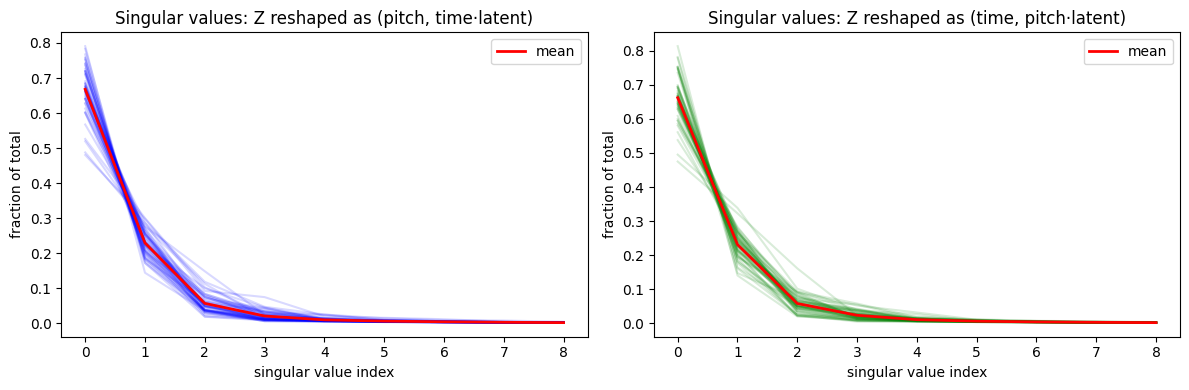

In [ ]:
@torch.no_grad()
def grid_embeddings(enc, n_blobs=50, sz=16, max_shift=4):
    """Encode a grid of (dy, dx) shifts for each blob."""
    shifts = list(range(-max_shift, max_shift+1))  # e.g. -4..+4 = 9 values
    all_Z = []
    for _ in range(n_blobs):
        img = make_blob(sz).unsqueeze(0).to(device)
        Z = []
        for dy in shifts:
            for dx in shifts:
                shifted = shift_no_wrap(shift_no_wrap(img, shifts=dy, dims=2), shifts=dx, dims=3)
                z = enc(shifted).squeeze().cpu()
                Z.append(z)
        all_Z.append(torch.stack(Z).reshape(len(shifts), len(shifts), -1))
    return torch.stack(all_Z), shifts  # (n_blobs, n_dy, n_dx, latent_dim)

Z, shifts = grid_embeddings(enc)
n_dy, n_dx, latent = Z.shape[1], Z.shape[2], Z.shape[3]
print(f"Z shape: {Z.shape}  (blobs, dy, dx, latent)")

# For each blob, reshape to (n_dy, n_dx*latent) and get singular values
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
all_sv = []
for i in range(len(Z)):
    M = Z[i].reshape(n_dy, n_dx * latent).numpy()
    sv = np.linalg.svd(M, compute_uv=False)
    sv_normed = sv / sv.sum()
    all_sv.append(sv_normed)
    axes[0].plot(sv_normed, alpha=0.15, color='blue')

mean_sv = np.stack(all_sv).mean(0)
axes[0].plot(mean_sv, color='red', linewidth=2, label='mean')
axes[0].set_xlabel('singular value index'); axes[0].set_ylabel('fraction of total')
axes[0].set_title('Singular values: Z reshaped as (pitch, time·latent)')
axes[0].legend()

# Same but transposed: (n_dx, n_dy*latent)
all_sv_t = []
for i in range(len(Z)):
    M = Z[i].permute(1, 0, 2).reshape(n_dx, n_dy * latent).numpy()
    sv = np.linalg.svd(M, compute_uv=False)
    sv_normed = sv / sv.sum()
    all_sv_t.append(sv_normed)
    axes[1].plot(sv_normed, alpha=0.15, color='green')

mean_sv_t = np.stack(all_sv_t).mean(0)
axes[1].plot(mean_sv_t, color='red', linewidth=2, label='mean')
axes[1].set_xlabel('singular value index'); axes[1].set_ylabel('fraction of total')
axes[1].set_title('Singular values: Z reshaped as (time, pitch·latent)')
axes[1].legend()

plt.tight_layout(); plt.show()


## Deeper analysis: Kernel PCA and SVD

The cosine histograms confirm that the soft loss achieves the desired geometric relationships. But does the latent space admit a **tensor-product** structure — i.e., can embeddings be decomposed into pitch ⊗ time components?

We use two complementary analyses:

1. **Kernel PCA** with an RBF kernel (inspired by Albinet's (2026) connection between soft constraints and eigenstructure via kernel methods). The RBF kernel can reveal nonlinear factored structure that linear PCA would miss. Results show that the first two kernel principal components cleanly separate pitch and time with orthogonal gradients, while kPC3–4 contain no factor-related structure — confirming a 2D factored subspace.

2. **SVD on a grid of shift embeddings**: For each blob, we encode a full grid of (pitch, time) shifts and reshape as a matrix. The first singular value captures 60–80% of the total energy, with most of the remainder in just 2–3 components — indicating approximately low-rank (near tensor-product) structure in the learned embeddings.

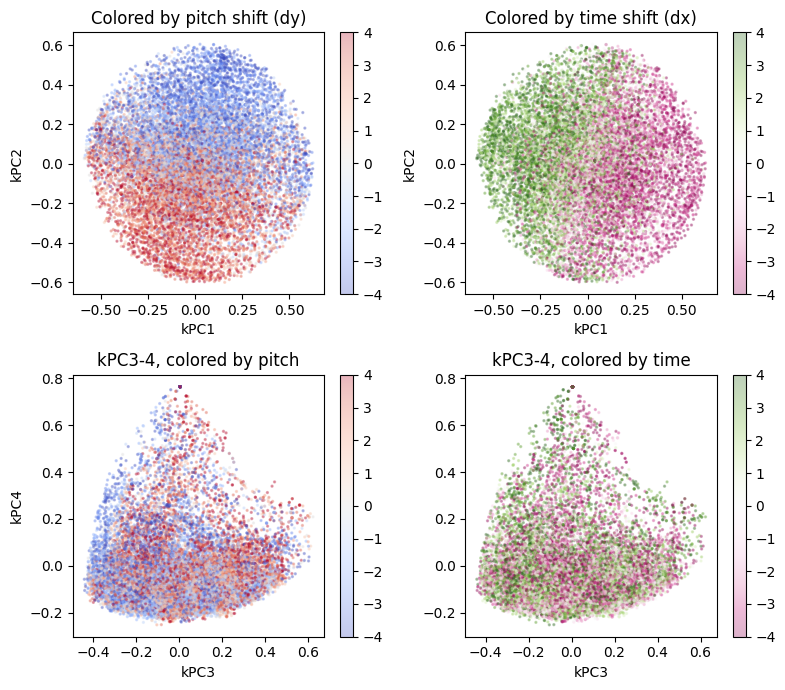

In [ ]:
# kernel pca 

from sklearn.decomposition import KernelPCA

@torch.no_grad()
def kernel_pca_analysis(enc, n_blobs=200, sz=16, max_shift=4, gamma=1.0):
    """Encode shifted blobs and apply kernel PCA to reveal nonlinear structure."""
    shifts = list(range(-max_shift, max_shift+1))
    embeddings, dy_labels, dx_labels = [], [], []
    for _ in range(n_blobs):
        img = make_blob(sz).unsqueeze(0).to(device)
        for dy in shifts:
            for dx in shifts:
                shifted = shift_no_wrap(shift_no_wrap(img, shifts=dy, dims=2), shifts=dx, dims=3)
                z = enc(shifted).squeeze().cpu().numpy()
                embeddings.append(z)
                dy_labels.append(dy)
                dx_labels.append(dx)
    X = np.stack(embeddings)
    dy_labels, dx_labels = np.array(dy_labels), np.array(dx_labels)

    kpca = KernelPCA(n_components=4, kernel='rbf', gamma=gamma)
    Z = kpca.fit_transform(X)

    fig, axs = plt.subplots(2, 2, figsize=(8, 7))
    axes = axs.flatten()
    sc0 = axes[0].scatter(Z[:, 0], Z[:, 1], c=dy_labels, cmap='coolwarm', s=2, alpha=0.3)
    axes[0].set_xlabel('kPC1'); axes[0].set_ylabel('kPC2')
    axes[0].set_title('Colored by pitch shift (dy)')
    plt.colorbar(sc0, ax=axes[0])

    sc1 = axes[1].scatter(Z[:, 0], Z[:, 1], c=dx_labels, cmap='PiYG', s=2, alpha=0.3)
    axes[1].set_xlabel('kPC1'); axes[1].set_ylabel('kPC2')
    axes[1].set_title('Colored by time shift (dx)')
    plt.colorbar(sc1, ax=axes[1])

    sc2 = axes[2].scatter(Z[:, 2], Z[:, 3], c=dy_labels, cmap='coolwarm', s=2, alpha=0.3)
    axes[2].set_xlabel('kPC3'); axes[2].set_ylabel('kPC4')
    axes[2].set_title('kPC3-4, colored by pitch')
    plt.colorbar(sc2, ax=axes[2])

    sc3 = axes[3].scatter(Z[:, 2], Z[:, 3], c=dx_labels, cmap='PiYG', s=2, alpha=0.3)
    axes[3].set_xlabel('kPC3'); axes[2].set_ylabel('kPC4')
    axes[3].set_title('kPC3-4, colored by time')
    plt.colorbar(sc3, ax=axes[3])

    plt.tight_layout(); plt.show()
    return kpca, Z, dy_labels, dx_labels

kpca, Z, dy_lab, dx_lab = kernel_pca_analysis(enc, gamma=1.0)


In [ ]:
!uv pip install umap-learn

Using Python 3.10.12 environment at: /home/shawley/envs/midi-rae
Resolved 10 packages in 366ms                                        
Prepared 2 packages in 38ms                                              
Installed 2 packages in 2ms                                 
 + pynndescent==0.6.0
 + umap-learn==0.5.11


## Does UMAP Show Us Anything? 

If the nonlinear PCA with the RBF kernel is showing a clean separation, does that mean that there's a two-dimensional subspace manifold at work? Maybe UMAP can discover this manifold and show us something interesting.

Spoiler: No, This is pretty much a jumbled mess because the UMAP focuses on the local structure and twists everything around:

/home/shawley/envs/midi-rae/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


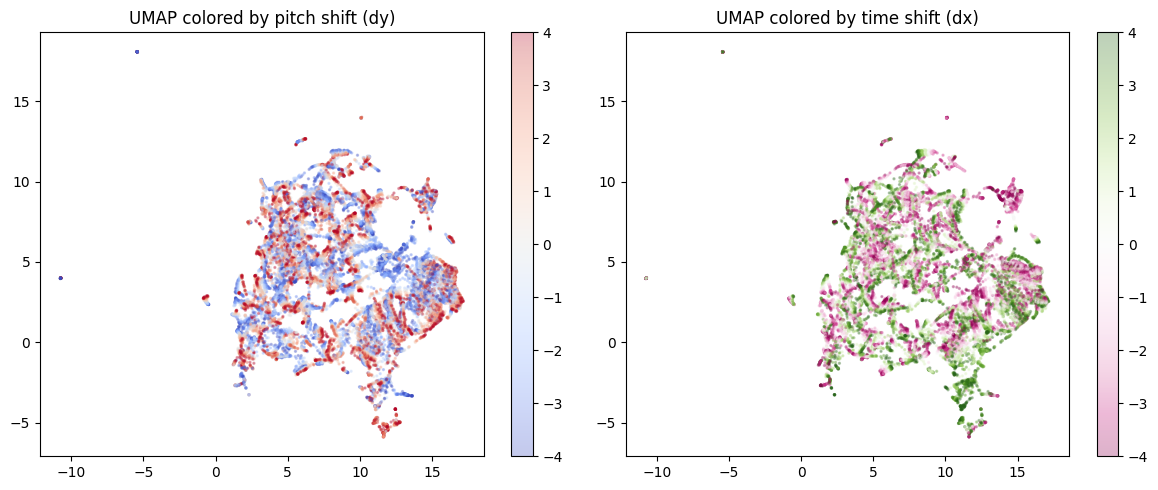

In [ ]:
# Umap 
import umap

@torch.no_grad()
def umap_analysis(enc, n_blobs=200, sz=16, max_shift=4):
    shifts = list(range(-max_shift, max_shift+1))
    embeddings, dy_labels, dx_labels = [], [], []
    for _ in range(n_blobs):
        img = make_blob(sz).unsqueeze(0).to(device)
        for dy in shifts:
            for dx in shifts:
                shifted = shift_no_wrap(shift_no_wrap(img, shifts=dy, dims=2), shifts=dx, dims=3)
                z = enc(shifted).squeeze().cpu().numpy()
                embeddings.append(z)
                dy_labels.append(dy)
                dx_labels.append(dx)
    X = np.stack(embeddings)
    dy_labels, dx_labels = np.array(dy_labels), np.array(dx_labels)

    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
    Z = reducer.fit_transform(X)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sc0 = axes[0].scatter(Z[:, 0], Z[:, 1], c=dy_labels, cmap='coolwarm', s=2, alpha=0.3)
    axes[0].set_title('UMAP colored by pitch shift (dy)')
    plt.colorbar(sc0, ax=axes[0])

    sc1 = axes[1].scatter(Z[:, 0], Z[:, 1], c=dx_labels, cmap='PiYG', s=2, alpha=0.3)
    axes[1].set_title('UMAP colored by time shift (dx)')
    plt.colorbar(sc1, ax=axes[1])

    plt.tight_layout(); plt.show()
    return reducer, Z, dy_labels, dx_labels

reducer, Z_umap, dy_lab, dx_lab = umap_analysis(enc)


What if we went to 3D instead of 2D? Would it let us see more? 

Answer: not really.

/home/shawley/envs/midi-rae/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


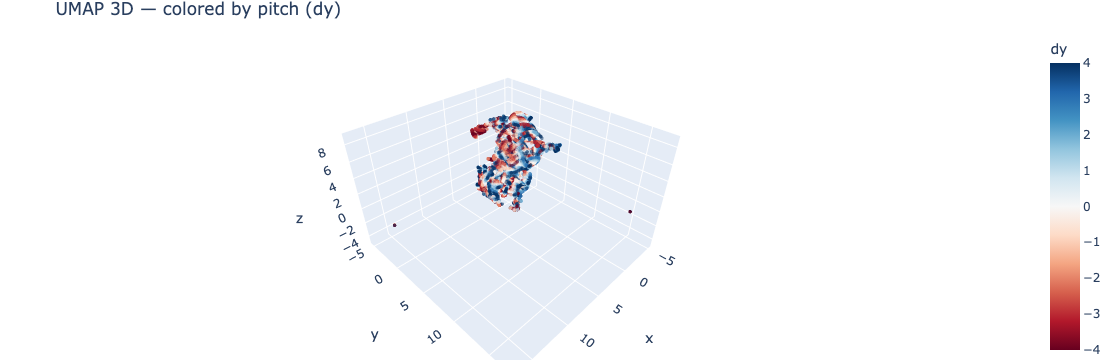

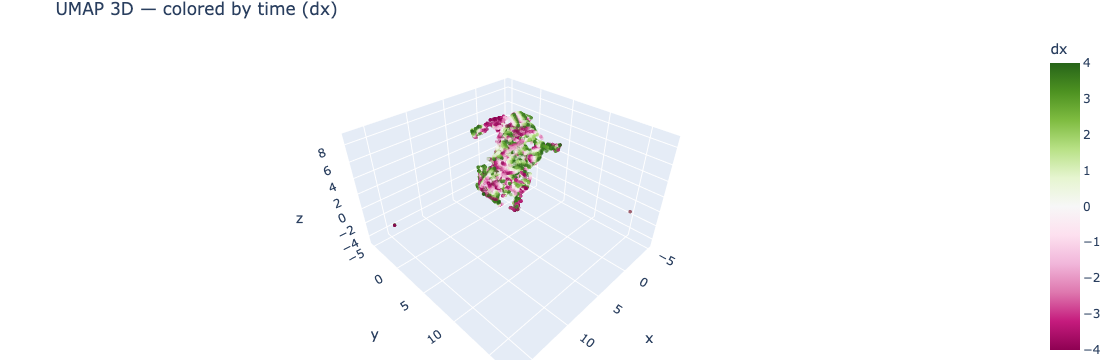

In [ ]:
import plotly.graph_objects as go

@torch.no_grad()
def umap_3d_analysis(enc, n_blobs=200, sz=16, max_shift=4):
    shifts = list(range(-max_shift, max_shift+1))
    embeddings, dy_labels, dx_labels = [], [], []
    for _ in range(n_blobs):
        img = make_blob(sz).unsqueeze(0).to(device)
        for dy in shifts:
            for dx in shifts:
                shifted = shift_no_wrap(shift_no_wrap(img, shifts=dy, dims=2), shifts=dx, dims=3)
                z = enc(shifted).squeeze().cpu().numpy()
                embeddings.append(z)
                dy_labels.append(dy)
                dx_labels.append(dx)
    X = np.stack(embeddings)
    dy_labels, dx_labels = np.array(dy_labels), np.array(dx_labels)

    reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
    coords = reducer.fit_transform(X)

    fig_pitch = go.Figure(data=[go.Scatter3d(
        x=coords[:,0], y=coords[:,1], z=coords[:,2],
        mode='markers',
        marker=dict(size=2, color=dy_labels, colorscale='RdBu', opacity=0.5,
                    colorbar=dict(title='dy')),
        hovertext=[f"dy={dy}, dx={dx}" for dy, dx in zip(dy_labels, dx_labels)],
        hoverinfo='x+y+z+text'
    )])
    fig_pitch.update_layout(title='UMAP 3D — colored by pitch (dy)', margin=dict(l=0, r=0, b=0, t=30))

    fig_time = go.Figure(data=[go.Scatter3d(
        x=coords[:,0], y=coords[:,1], z=coords[:,2],
        mode='markers',
        marker=dict(size=2, color=dx_labels, colorscale='PiYG', opacity=0.5,
                    colorbar=dict(title='dx')),
        hovertext=[f"dy={dy}, dx={dx}" for dy, dx in zip(dy_labels, dx_labels)],
        hoverinfo='x+y+z+text'
    )])
    fig_time.update_layout(title='UMAP 3D — colored by time (dx)', margin=dict(l=0, r=0, b=0, t=30))

    fig_pitch.show()
    fig_time.show()
    return coords, dy_labels, dx_labels

coords, dy_lab, dx_lab = umap_3d_analysis(enc)


## Discussion

So where are we going with this? The idea that factorization in pitch and time is useful but not the complete picture seems to be borne out and supported by the soft factorization method, which would allow us some level of interpretable controls or structure without forcing it in a detrimental way.

The fact that our augmentation scheme allows us to explicitly label the degree to which we're Performing the augmentations is a key aspect of this method, i.e., if you were just doing other types of augmentations, you might not be able to pull this off.

I'll mention that when Christian Steinmetz and I looked at directions for audio effects parameters in latent space (Hawley & Steinmetz, 2023), it was....okay, but ultimately kind of disappointing. Because CLAP embeddings suck. Anyway, this work is kind of on the continuum with that. And the OpLaS paper for letting the latent space encode transformations geometrically.

**"Selling Points":** 
* I like flexibility of the implementation. It doesn't require any architecture changes at all as it would if you were going to try to do the factorization by construction. You just add it as a loss term.
* Furthermore, it's tunable. You can sort of weight how strongly you want the factorization thing to take hold just by tuning a regularization parameter in the overall loss term. That's got to be worth some attention from the machine learning community, right? LOL

## References

**Inspiration: Franck's series, Soft constraints and kernel methods:**
- F. Albinet, "(Part 1) SVD Through Variational Principles: From Geometry to the Classical Formulation," blog post, Jan 20, 2026. https://fr.anckalbi.net/posts/svd-geometry-to-variational/
- F. Albinet, "(Part 2) Ridges and Thalwegs: The Landscape of Competing Forces — PCA through the LS-SVM lens, preparing the path to SVD and beyond," blog post, Feb. 20, 2026. https://fr.anckalbi.net/posts/ls-svm-kernel-pca/

**My Prior Work on Latent Encoding of Data Transformations, Translations, Rotations, Etc:**
- S.H. Hawley & A. Tackett, "Operational Latent Spaces (OpLaS)," AES International Symposium on AI and the Musician,  https://drscotthawley.github.io/oplas/
- S.H. Hawley & C. J. Steinmetz, "Leveraging Neural Representations for Audio Manipulation," JAES / AES Europe 2023. https://arxiv.org/abs/2304.04394

**Factored representations in symbolic music:**
- X. Wu, Z. Huang, K. Zhang, J. Yu, X. Tan, T. Zhang, Y. Li, Z. Wang, and L. Sun, "MelodyGLM: Multi-task Pre-training for Symbolic Melody Generation," arXiv:2309.10738, September 2023.
- K. Chen, G. Xia, and S. Dubnov, "Music SketchNet: Controllable Music Generation via Factorized Representations of Pitch and Rhythm," arXiv:2008.01291, 2020.
- H. Liang, T. Mu, and R. Cai, "PiRhDy: Learning Pitch-, Rhythm-, and Dynamics-aware Embeddings for Symbolic Music," arXiv:2010.08091, 2020.
- Z. Wang, K. Chen, J. Jiang, Y. Zhang, M. Xu, S. Dai, X. Gu, and G. Xia, "MuseBERT: Pre-training Music Representation for Music Understanding and Controllable Generation," in Proc. ISMIR, 2021.

**Motif discovery and pattern repetition:**
- D. Meredith, K. Lemström, and G. A. Wiggins, "Algorithms for discovering repeated patterns in multidimensional representations of polyphonic music," *Journal of New Music Research*, vol. 31, no. 4, pp. 321–345, 2002.
- D. Meredith, "COSIATEC and SIATECCompress: Pattern discovery by geometric compression," in MIREX, Curitiba, Brazil, 2013.
- E. Cambouropoulos, M. Crochemore, C. Iliopoulos, L. Mouchard, and Y. Pinzon, "Algorithms for computing approximate repetitions in musical sequences," *International Journal of Computer Mathematics*, vol. 79, no. 11, pp. 1135–1148, 2002.
- C.-C. M. Yeh, Y. Zhu, L. Ulanova, N. Begum, Y. Ding, H. A. Dau, D. F. Silva, A. Mueen, and E. Keogh, "Matrix Profile I: All pairs similarity joins for time series," in Proc. IEEE ICDM, Barcelona, Spain, 2016, pp. 1317–1322.
- "SIATEC-C: Computationally Efficient Repeated Pattern Discovery in Polyphonic Music," in Proc. ISMIR, 2022. https://archives.ismir.net/ismir2022/paper/000006.pdf

**Datasets: (The main code so far is only using POP909).**
- Z. Wang, K. Chen, J. Jiang, Y. Zhang, M. Xu, S. Dai, X. Gu, and G. Xia, "POP909: A Pop-song Dataset for Music Arrangement Generation," in Proc. 21st International Society for Music Information Retrieval Conference (ISMIR), Montréal, Canada, 2020, pp. 38–45.
- "BPS-Motif: A Dataset for Repeated Pattern Discovery of Polyphonic Symbolic Music," in Proc. ISMIR, 2023. https://archives.ismir.net/ismir2023/paper/000032.pdf

**Representation AutoEncoder (RAE) & more:**
- B. Zheng, N. Ma, S. Tong, and S. Xie, "Diffusion Transformers with Representation Autoencoders," arXiv:2510.11690, 2025.
- K. Didi, "The unification of representation learning and generative modelling," https://kdidi.netlify.app/blog/ml/2025-12-31-r4g/, Dec 31, 2025.

**LeJEPA**: 
- R. Balestriero and Y. LeCun, "LeJEPA: Provable and Scalable Self-Supervised Learning Without the Heuristics", Nov. 2025, https://arxiv.org/abs/2511.08544

**Factored representations in transformers:**
- A. Shai, L. Amdahl-Culleton, C. L. Christensen, H. R. Bigelow, F. E. Rosas, A. B. Boyd, E. A. Alt, K. J. Ray, and P. M. Riechers, "Transformers learn factored representations," arXiv:2602.02385, February 2026.

**Factored word embeddings:**
- J. Pennington, R. Socher, and C. D. Manning, "GloVe: Global Vectors for Word Representation," in Proc. EMNLP, 2014, pp. 1532–1543. https://nlp.stanford.edu/pubs/glove.pdf

**Disentangled and geometric representations:**
- E. Härkönen, A. Hertzmann, J. Lehtinen, and S. Paris, "GANSpace: Discovering Interpretable GAN Controls," in Proc. NeurIPS, 2020.
- I. Higgins et al., "beta-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework," in Proc. ICLR, 2017.
- G. Velarde, D. Meredith, and T. Weyde, "A wavelet-based approach to pattern discovery in melodies," Springer Cham, 2016, pp. 303–333.